# Prediction and Forecasting Results in the English Premier League

## Transfermarkt value

The object this week is to forecast the outcome of soccer games. We are going to show how to do this using the English Premier League as our example. However, you could easily adapt our method to professional soccer leagues around the world. 

We learnt in Course 1 that player salaries in the English Premier League are closely correlated with team performance in the league (see Course 1, Week 5). This reflects the nature of the market. It's not that higher salaries get players to try harder (most professional soccer players don't need much motivation). Rather, there is a market for players with many buyers and sellers, and the ability of players is realtively easy to order, so that each player commands a salary relative to other players that matches his position in the hierarchy of ability (more or less).

We can obtain data on salary spending of EPL clubs from their financial statements which are freely available online from the website of Companies House. However, this is little use to us if we want to forecast the results of games, since the financial statements are not published until at least six months after the season ends (and often a lot longer). While wages are a good predictor of results because they reflect the ability of players, from one season to the next teams trade players, so last year's wages will not be a good predictor of this year's performance.

To make forecasts, we need something that is as reliable as the wage data, but is contemporaneous with the games being played. Fortunately, we have something.

Transfermarkt is website that provides a valuation for thousands of professional players for dozens of leagues around the world (it has various handles for its website, such as https://www.transfermarkt.de/, https://www.transfermarkt.us/, https://www.transfermarkt.co.uk/, https://www.transfermarkt.fr/). The value is an estimate or the transfer price that would be paid for a player to move from one club to another. The valuations are updated at regular intervals, and are generated by a version of "crowdsourcing" - aggregating the opinions of many different individuals. Here is a description of the method:

"Transfermarkt.de, Germany’s leading online soccer community and one of the largest sport websites on the German language Internet, applies the judge principle. Every interested person can register for free on the transfermarkt.de community and discuss market values of thousands of soccer players playing in various countries and divisions. Commonly, a member proposes a market value for a player and provides a rationale for this number, for example, by arguing about one or more of the player’s attributes to justify his or her market-value estimation. Every community member can follow the discussion threads of all the players’ market values and users can contribute based on criteria that are most important to them personally. However, only a few merited community members are discussion leaders – ‘‘judges’’ in the language of our research. Judges have earned superior rights and make the final decisions about market-value suggestions that are posted by community members."

(Herm, S., Callsen-Bracker, H. M., & Kreis, H. (2014). When the crowd evaluates soccer players’ market values: Accuracy and evaluation attributes of an online community. Sport Management Review, 17(4), 484-492).

Relying on these subjective valuations would be a leap of faith without first checking that they are correlated with an objective measure of value. Here we check the total transfermarkt values of team squads from past years with the measures of wages and salaries taken from the financial statements of the Premier League clubs.

To do this we will use a datafile of Premier League club wages and merge it with a datafile TM values. We will look at the correlation by means of a scatter diagram, and then run a regression to see how closely the two datasets fit.

In [1]:
# This code widens the working frame to fill the full screenwidth, which is often useful.

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

We now import two datasets, one with the wage data from the financial statements, the other with the values from Transfermarkt (TM). Note that the seasons covered by the two datasets are not identical. When working with data on leagues whose seasons start and end in different calendar years its important to be sure which season you are referring to. For the TM data the filename refers to both years- e.g. the season 2010-11. For the wage data it just refers to single year for each season - e.g. 2018. Here our convention when using a single year to refer to a season is the identify the year in which the season ended, e.g. 2018 refers to the season 2017-18.

In [2]:
# Here we import the packages we will need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:
wagedat=pd.read_excel("D:\\GitHub\\Coursera\\SportsPerformanceAnalytics\\PredictionModelsWithSportsData\\data\\EPL club wages and position 1997-2018.xlsx")
TMdat = pd.read_excel("D:\\GitHub\\Coursera\\SportsPerformanceAnalytics\\PredictionModelsWithSportsData\\data\\EPL TM values 2010-11 to 2019-20.xlsx")

In [4]:
# Because of the promotion and relegation system, there are many more than 20 clubs in our data, even though there were only ever 20 clubs in the Premier League in any one season. 
#We can see which clubs appeared by listing the unique elements of the "Club" variable in our wage data file.

wagedat['Club'].unique()

array(['Arsenal', 'Aston Villa', 'Barnsley', 'Birmingham City',
       'Blackburn Rovers', 'Blackpool', 'Bolton Wanderers', 'Bournemouth',
       'Bradford City', 'Brighton & Hove Albion', 'Burnley',
       'Cardiff City', 'Charlton Athletic', 'Chelsea', 'Coventry City',
       'Crystal Palace', 'Derby County', 'Everton', 'Fulham',
       'Huddersfield Town', 'Hull City', 'Ipswich Town', 'Leeds United',
       'Leicester City', 'Liverpool', 'Manchester City',
       'Manchester United', 'Middlesbrough', 'Newcastle United',
       'Norwich City', 'Nottingham Forest', 'Portsmouth',
       'Queens Park Rangers', 'Reading', 'Sheffield United',
       'Sheffield Wednesday', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur', 'Watford',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Wimbledon', 'Wolverhampton Wanderers'], dtype=object)

In [5]:
# Likewise we can list the unique elements of the "Club" variable in the TM data. Note this has fewer clubs, since the data covers a shorter period.

TMdat['Club'].unique()

array(['Arsenal', 'Aston Villa', 'Birmingham City', 'Blackburn Rovers',
       'Blackpool', 'Bolton Wanderers', 'Chelsea', 'Everton', 'Fulham',
       'Liverpool', 'Manchester City', 'Manchester United',
       'Newcastle United', 'Stoke City', 'Sunderland',
       'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United',
       'Wigan Athletic', 'Wolverhampton Wanderers', 'Norwich City',
       'Queens Park Rangers', 'Swansea City', 'Reading', 'Southampton',
       'Cardiff City', 'Crystal Palace', 'Hull City', 'Burnley',
       'Leicester City', 'Bournemouth', 'Watford', 'Middlesbrough',
       'Brighton & Hove Albion', 'Huddersfield Town', 'Sheffield United'],
      dtype=object)

In [6]:
# We can use .describe() to view the the dimensions of the wage data...

wagedat.describe(include='all')

,seasonyrend,Club,Position,wages
count,440.000000,440,440.000000,4.350000e+02
unique,NaN,47,NaN,NaN
top,NaN,Arsenal,NaN,NaN
freq,NaN,22,NaN,NaN
mean,2007.500000,NaN,10.500000,6.197073e+07
std,6.351511,NaN,5.772845,5.387372e+07
min,1997.000000,NaN,1.000000,4.172024e+06
25%,2002.000000,NaN,5.750000,2.640600e+07
50%,2007.500000,NaN,10.500000,4.529037e+07
75%,2013.000000,NaN,15.250000,7.754100e+07


In [7]:
# ...and the TM data

TMdat.describe(include='all')

,seasonyrbegin,seasonyrend,Club,TMValue
count,200.000000,200.000000,200,200.000000
unique,NaN,NaN,36,NaN
top,NaN,NaN,Arsenal,NaN
freq,NaN,NaN,10,NaN
mean,2014.500000,2015.500000,NaN,218.767100
std,2.879489,2.879489,NaN,198.041615
min,2010.000000,2011.000000,NaN,20.630000
25%,2012.000000,2013.000000,NaN,82.182500
50%,2014.500000,2015.500000,NaN,141.640000
75%,2017.000000,2018.000000,NaN,299.310000


To compare the wage bill of each club with its TM value we need to do a merge, so we must first create a unique id in each df. We can do this by concatenating 'Club' and 'seasonyrend' in each df to create such an id. Note that for this to work the names have to be compatible. An easy mistake when merging files is to have different names for the same team. e.g. some sources might refer to "Manchester City" while others might abbreviate this to "Man City". Here the names were pre-checked to make sure they are compatible.

In [8]:
wagedat['teamid'] = wagedat['Club']+wagedat['seasonyrend'].map(str)
wagedat

,seasonyrend,Club,Position,wages,teamid
0,1997,Arsenal,3,15279000.0,Arsenal1997
1,1998,Arsenal,1,21882000.0,Arsenal1998
2,1999,Arsenal,2,26478000.0,Arsenal1999
3,2000,Arsenal,2,33970000.0,Arsenal2000
4,2001,Arsenal,2,40651000.0,Arsenal2001
...,...,...,...,...,...
435,2000,Wimbledon,18,15770522.0,Wimbledon2000
436,2004,Wolverhampton Wanderers,20,19278845.0,Wolverhampton Wanderers2004
437,2010,Wolverhampton Wanderers,15,29800808.0,Wolverhampton Wanderers2010
438,2011,Wolverhampton Wanderers,17,37915000.0,Wolverhampton Wanderers2011


In [9]:
# create the same team/year id in TMdat

TMdat['teamid'] = TMdat['Club']+TMdat['seasonyrend'].map(str)
TMdat

,seasonyrbegin,seasonyrend,Club,TMValue,teamid
0,2010,2011,Arsenal,272.70,Arsenal2011
1,2010,2011,Aston Villa,127.94,Aston Villa2011
2,2010,2011,Birmingham City,68.00,Birmingham City2011
3,2010,2011,Blackburn Rovers,65.93,Blackburn Rovers2011
4,2010,2011,Blackpool,24.37,Blackpool2011
...,...,...,...,...,...
195,2019,2020,Southampton,209.70,Southampton2020
196,2019,2020,Tottenham Hotspur,881.55,Tottenham Hotspur2020
197,2019,2020,Watford,214.52,Watford2020
198,2019,2020,West Ham United,299.03,West Ham United2020


We can now use pd.merge. By listing TMdat first we merge the data from wagedat into TMdat. We specify the variables to be added in the merge ('teamid' and'wages'), and specify the common variable which aligns the two dfs ('teamid').

In [10]:
TMdat = pd.merge(TMdat,wagedat[['teamid','wages']], on= 'teamid', how = 'left')
TMdat

,seasonyrbegin,seasonyrend,Club,TMValue,teamid,wages
0,2010,2011,Arsenal,272.70,Arsenal2011,124401000.0
1,2010,2011,Aston Villa,127.94,Aston Villa2011,83395000.0
2,2010,2011,Birmingham City,68.00,Birmingham City2011,45088340.0
3,2010,2011,Blackburn Rovers,65.93,Blackburn Rovers2011,49869577.0
4,2010,2011,Blackpool,24.37,Blackpool2011,26014248.0
...,...,...,...,...,...,...
195,2019,2020,Southampton,209.70,Southampton2020,NaN
196,2019,2020,Tottenham Hotspur,881.55,Tottenham Hotspur2020,NaN
197,2019,2020,Watford,214.52,Watford2020,NaN
198,2019,2020,West Ham United,299.03,West Ham United2020,NaN


## Self Test - 1

Create the merged file but include the 'Position' variable from the wagedat df as well.

In [11]:
#Your Code Here

In [11]:
# The TM data is expressed in £ million, while the wage data is in £. We can convert to common units by dividing wages by 1 million, 
# although this is not strictly necessary for the purpose of measuring correlation.

TMdat['wages']=TMdat['wages']/1000000
TMdat

,seasonyrbegin,seasonyrend,Club,TMValue,teamid,wages
0,2010,2011,Arsenal,272.70,Arsenal2011,124.401000
1,2010,2011,Aston Villa,127.94,Aston Villa2011,83.395000
2,2010,2011,Birmingham City,68.00,Birmingham City2011,45.088340
3,2010,2011,Blackburn Rovers,65.93,Blackburn Rovers2011,49.869577
4,2010,2011,Blackpool,24.37,Blackpool2011,26.014248
...,...,...,...,...,...,...
195,2019,2020,Southampton,209.70,Southampton2020,NaN
196,2019,2020,Tottenham Hotspur,881.55,Tottenham Hotspur2020,NaN
197,2019,2020,Watford,214.52,Watford2020,NaN
198,2019,2020,West Ham United,299.03,West Ham United2020,NaN


First, let's look at the correlation using a scatter diagram for all of the data. Using relplot in Seaborn (sns) we can see that the correlation is very close. Using "hue" helps us to see how the data varies by year, but in fact the pattern is pretty consistent across all years.

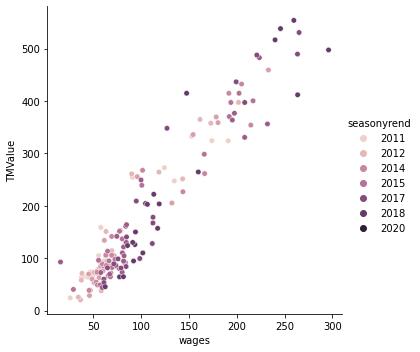

In [12]:
sns.relplot(x="wages", y="TMValue", data = TMdat, s=30, hue = "seasonyrend")

<AxesSubplot:xlabel='wages', ylabel='TMValue'>

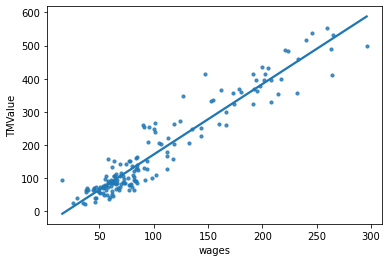

In [13]:
# If we use 'regplot' instead of 'relplot', we can add a regression line to the chart.

sns.regplot(x="wages", y="TMValue", data = TMdat, scatter_kws={'s':10}, ci = False)

## Self Test - 2

Generate a relplot or regplot for (a) wages and Position and (b) TMValue and Position.

In [15]:
#Your Code Here

Having looked at the data, the next step is to run a regression to estimate exactly how closely the two data sets fit. We can run a regression for all eight seasons for which we have data:

In [14]:
TMwage_lm = smf.ols(formula = 'TMValue ~ wages', data=TMdat).fit()
TMwage_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TMValue   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1575.
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           4.46e-84
Time:                        10:37:53   Log-Likelihood:                -823.24
No. Observations:                 160   AIC:                             1650.
Df Residuals:                     158   BIC:                             1657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -41.3114      6.418     -6.436      0.000     -53.988     -28.634
wages          2.1262      0.054     39.687      0.000       2.020       2.232
==============================================================================
Omnibus:                       11.482   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.844
Skew:                           0.531   Prob(JB):                      0.00163
Kurtosis:                       3.893   Cond. No.                         233.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see from the regression that there is a very close fit. The R-Squared is 0.91 and the standard error of the wage coefficient is very small relative to the coefficient estimate, which a very large t-statistic and a p-value which is very small. Essentially the TM values for the players at any club is just over twice the value of the wage spending.

While this should reassure us that TM values are indeed reliable estimates of player market values, we should check to see that the estimates are consistent from year to year, and not subject to large fluctations. We can run a regression for each year, but for ease of comparison we want to use the same presentation method that we used in Course 2, reporting the coefficients estimates for each series in aligned columns. 

To do this we use the summary_col command, and add the extra lines which enable us to report the number of observations and R-Squared of the regression. 

First, we just report the regression for all seasons in this format:

In [15]:
from statsmodels.iolib.summary2 import summary_col
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}
TMwage_Out = summary_col(TMwage_lm,info_dict = info_dict)
print(TMwage_Out)


                 TMValue 
-------------------------
Intercept        -41.3114
                 (6.4184)
wages            2.1262  
                 (0.0536)
R-squared        0.9088  
R-squared Adj.   0.9083  
R-squared        0.91    
No. observations 160     
Standard errors in
parentheses.


We have eight seasons of data. We begin by defining eight dfs, each of which is a subset for a single season. Then we run the regression for each season. Then, we define headers for each column of our output (AllTM). Finally, we define the table of results and print this to display the results.

In [16]:
TM2011 = TMdat[TMdat.seasonyrend == 2011]
TM2012 = TMdat[TMdat.seasonyrend == 2012]
TM2013 = TMdat[TMdat.seasonyrend == 2013]
TM2014 = TMdat[TMdat.seasonyrend == 2014]
TM2015 = TMdat[TMdat.seasonyrend == 2015]
TM2016 = TMdat[TMdat.seasonyrend == 2016]
TM2017 = TMdat[TMdat.seasonyrend == 2017]
TM2018 = TMdat[TMdat.seasonyrend == 2018]

TM2011_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2011).fit()
TM2012_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2012).fit()
TM2013_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2013).fit()
TM2014_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2014).fit()
TM2015_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2015).fit()
TM2016_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2016).fit()
TM2017_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2017).fit()
TM2018_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2018).fit()


AllTM = ["All",'2011','2012','2013','2014','2015','2016','2017','2018']

TMAll_Out = summary_col([TMwage_lm,TM2011_lm, TM2012_lm,TM2013_lm, TM2014_lm,TM2015_lm,TM2016_lm, TM2017_lm,TM2018_lm],\
                        model_names = AllTM, stars=True, info_dict = info_dict)

print(TMAll_Out)


                     All        2011      2012        2013       2014        2015       2016       2017       2018   
---------------------------------------------------------------------------------------------------------------------
Intercept        -41.3114*** -16.0649  -41.9445** -51.8969*** -42.3952** -55.7933*** -24.8110  -76.4519*** -72.4432**
                 (6.4184)    (13.9340) (14.6265)  (13.5827)   (16.9183)  (14.2330)   (21.0048) (22.2210)   (29.6730) 
wages            2.1262***   2.0355*** 2.3286***  2.2880***   2.1202***  2.2213***   1.9026*** 2.3548***   2.2253*** 
                 (0.0536)    (0.1507)  (0.1541)   (0.1303)    (0.1550)   (0.1228)    (0.1683)  (0.1574)    (0.1857)  
R-squared        0.9088      0.9102    0.9270     0.9448      0.9123     0.9478      0.8766    0.9256      0.8886    
R-squared Adj.   0.9083      0.9052    0.9229     0.9418      0.9074     0.9450      0.8697    0.9214      0.8825    
R-squared        0.91        0.91      0.93       0.94 

From the table we can see that the coefficient on wages is relatively stable from year to year, varying between 1.90 (2016) and 2.35 (2017). In each season the R-Squared implies a very close correlation.

## Self Test - 3

Run a regression of Position on (a) wages and (b) TMValue for all the seasons combined (i.e. not season by season) and compare the two regressions. What do you notice? 

In [19]:
#Your Code Here

# Conclusion

This exercise should give us confidence that TM values can be used as a measure of player quality, since they are closely correlated with club wage bills, which we have already established are a good predictor of team performance. 

We will now explore how good the TM data is at predicting past results, before going to to show how the model can be used to predict future results.
